# Preparación de datos
## Importaciones

In [2]:
!pip install dotenv
!pip install sqlalchemy
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns


   ---------------------------------------- 0/2 [python-dotenv]
   ---------------------------------------- 0/2 [python-dotenv]



ERROR: Could not install packages due to an OSError: [WinError 2] El sistema no puede encontrar el archivo especificado: 'C:\\Python312\\Scripts\\dotenv.exe' -> 'C:\\Python312\\Scripts\\dotenv.exe.deleteme'



   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------- ----- 1.8/2.1 MB 14.4 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 14.9 MB/s  0:00:00


## Lectura del Archivo CSV

In [3]:
contenido = pd.read_csv('./DB/ventas_tienda_online.csv')
contenido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          10002 non-null  int64  
 1   purchase_date     10002 non-null  object 
 2   customer_id       10002 non-null  int64  
 3   customer_gender   9998 non-null   object 
 4   customer_age      10000 non-null  float64
 5   product_category  10000 non-null  object 
 6   product_name      9986 non-null   object 
 7   product_price     10001 non-null  float64
 8   quantity          10002 non-null  int64  
 9   order_total       10002 non-null  float64
 10  payment_method    10000 non-null  object 
 11  shipping_region   10002 non-null  object 
dtypes: float64(3), int64(3), object(6)
memory usage: 937.8+ KB


## Limpieza General
* Eliminación de filas con valores nulos.
* Eliminación de filas duplicadas.

In [4]:
contenido.dropna(inplace=True)
contenido.drop_duplicates(inplace=True)

contenido.info()
print(f'Registros después de la limpieza: {len(contenido)}')

<class 'pandas.core.frame.DataFrame'>
Index: 9977 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          9977 non-null   int64  
 1   purchase_date     9977 non-null   object 
 2   customer_id       9977 non-null   int64  
 3   customer_gender   9977 non-null   object 
 4   customer_age      9977 non-null   float64
 5   product_category  9977 non-null   object 
 6   product_name      9977 non-null   object 
 7   product_price     9977 non-null   float64
 8   quantity          9977 non-null   int64  
 9   order_total       9977 non-null   float64
 10  payment_method    9977 non-null   object 
 11  shipping_region   9977 non-null   object 
dtypes: float64(3), int64(3), object(6)
memory usage: 1013.3+ KB
Registros después de la limpieza: 9977


## DataFrame de Clientes

In [5]:
clientes = contenido[['customer_id', 'customer_gender', 'customer_age']]\
    .drop_duplicates(subset=['customer_id'])

print(clientes)

      customer_id customer_gender  customer_age
0             822       Masculino          18.0
1             139        Femenino          18.0
2              86       Masculino          18.0
3             473       Masculino          18.0
4             113       Masculino          18.0
...           ...             ...           ...
5583          417       Masculino          52.0
5625           52       Masculino          52.0
7265          969       Masculino          63.0
7524          299        Femenino          64.0
8607          545        Femenino          71.0

[1000 rows x 3 columns]


## DataFrame de Categorias

In [6]:
categorias = contenido[['product_category']].drop_duplicates().reset_index(drop=True)
categorias['category_id'] = categorias.index + 1

print(categorias)

  product_category  category_id
0       Accesorios            1
1             Ropa            2
2          Calzado            3


## DataFrame de Productos

In [7]:
productos = contenido[['product_name', 'product_category', 'product_price']].drop_duplicates()
productos = productos.merge(categorias, on='product_category')\
    .drop(columns=['product_category'])
productos['product_id'] = productos.index + 1

print(productos)

     product_name  product_price  category_id  product_id
0           Bolso          90.72            1           1
1        Pantalón         131.68            2           2
2      Zapatillas          36.18            3           3
3         Vestido          78.55            2           4
4       Sandalias         116.37            3           5
...           ...            ...          ...         ...
9798     Cinturón          23.95            1        9799
9799     Pantalón         159.97            2        9800
9800    Pantuflas         158.81            3        9801
9801     Pantalón          28.25            2        9802
9802        Bolso         168.09            1        9803

[9803 rows x 4 columns]


## DataFrame de Métodos de Pago

In [8]:
metodos_pago = contenido[['payment_method']].drop_duplicates().reset_index(drop=True)
metodos_pago['payment_method_id'] = metodos_pago.index + 1

print(metodos_pago)

           payment_method  payment_method_id
0                  PayPal                  1
1  Transferencia bancaria                  2
2      Tarjeta de crédito                  3
3                Efectivo                  4


## DataFrame de Regiones de Envío

In [9]:
regiones_envio = contenido[['shipping_region']].drop_duplicates().reset_index(drop=True)
regiones_envio['region_id'] = regiones_envio.index + 1

print(regiones_envio)

  shipping_region  region_id
0           Oeste          1
1            Este          2
2          Centro          3
3           Norte          4
4             Sur          5


## DataFrame de Órdenes

In [10]:
ordenes = contenido[['order_id', 'purchase_date', 'customer_id', 'payment_method', 'shipping_region']].drop_duplicates()
ordenes = ordenes.merge(metodos_pago, on='payment_method')\
    .merge(regiones_envio, on='shipping_region')\
    .drop(columns=['payment_method', 'shipping_region'])

print(ordenes)

      order_id purchase_date  customer_id  payment_method_id  region_id
0           96       8/12/23          822                  1          1
1          142       3/09/23          139                  1          1
2          216      24/08/23           86                  2          2
3          235      15/03/23          473                  2          3
4          284      24/04/23          113                  3          4
...        ...           ...          ...                ...        ...
9972      9702      16/04/23          765                  4          5
9973      9774      21/04/23          774                  2          4
9974      9830      17/10/23          883                  1          2
9975      9886       5/11/23          306                  4          3
9976      9965      13/02/23          226                  4          5

[9977 rows x 5 columns]


## DataFrame de Orden Producto

In [11]:
orden_producto = contenido[['order_id', 'product_name', 'quantity', 'order_total']]
orden_producto = orden_producto.merge(productos[['product_name', 'product_id']], on='product_name')\
    .dropna(subset=['product_id', 'order_id'])\
    .drop(columns=['product_name'])
orden_producto = orden_producto[['order_id', 'product_id', 'quantity', 'order_total']]
orden_producto = orden_producto.drop_duplicates(subset=['order_id'])
orden_producto['id'] = list(range(1, len(orden_producto.index) + 1))

print(orden_producto)

         order_id  product_id  quantity  order_total    id
0              96           1         3       272.16     1
631           142           2         3       395.04     2
1273          216           3         1        36.18     3
1932          235           4         5       392.75     4
2551          284           5         1       116.37     5
...           ...         ...       ...          ...   ...
6522895      9702          12         2        47.90  9973
6523561      9774           2         3       479.91  9974
6524203      9830          14         2       317.62  9975
6524859      9886           2         4       113.00  9976
6525501      9965           1         4       672.36  9977

[9977 rows x 5 columns]


## Renombrando las Columnas de los DataFrames
Para que estén similares a los campos de la base de datos.

In [12]:
categorias = categorias.rename(columns={'category_id': 'id', 'product_category': 'nombre'})
productos = productos.rename(columns={
    'product_id': 'id', 'product_name': 'nombre', 'product_price': 'precio', 'category_id': 'categoria'
})
clientes = clientes.rename(columns={
    'customer_id': 'id', 'customer_gender': 'genero', 'customer_age': 'edad'
})
metodos_pago = metodos_pago.rename(columns={
    'payment_method_id': 'id', 'payment_method': 'nombre'
})
regiones_envio = regiones_envio.rename(columns={
    'region_id': 'id', 'shipping_region': 'nombre'
})
ordenes = ordenes.rename(columns={
    'order_id': 'id', 'purchase_date': 'fecha_compra', 'customer_id': 'cliente',
    'payment_method_id': 'metodo_pago', 'region_id': 'region_envio'
})
orden_producto = orden_producto.rename(columns={
    'order_id': 'orden', 'product_id': 'producto', 'quantity': 'cantidad', 'order_total': 'total'
})

## Carga de Variables de Entorno

In [13]:
load_dotenv()

host = os.getenv("DB_HOST", "localhost")
port = os.getenv("DB_PORT", "3306")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASS")
bd = os.getenv("DB_NAME")

## Conector

In [14]:
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{bd}')

## Vaciado de Tablas

In [15]:
with engine.begin() as conn:
    conn.execute(text("SET FOREIGN_KEY_CHECKS = 0"))
    conn.execute(text("TRUNCATE TABLE orden_producto"))
    conn.execute(text("TRUNCATE TABLE orden"))
    conn.execute(text("TRUNCATE TABLE producto"))
    conn.execute(text("TRUNCATE TABLE cliente"))
    conn.execute(text("TRUNCATE TABLE categoria"))
    conn.execute(text("TRUNCATE TABLE metodo_pago"))
    conn.execute(text("TRUNCATE TABLE region_envio"))
    conn.execute(text("SET FOREIGN_KEY_CHECKS = 1"))

## Inserción de Datos

In [16]:
categorias.to_sql('categoria', con=engine, if_exists='append', index=False)
productos.to_sql('producto', con=engine, if_exists='append', index=False)
clientes.to_sql('cliente', con=engine, if_exists='append', index=False)
metodos_pago.to_sql('metodo_pago', con=engine, if_exists='append', index=False)
regiones_envio.to_sql('region_envio', con=engine, if_exists='append', index=False)
ordenes.to_sql('orden', con=engine, if_exists='append', index=False)
orden_producto.to_sql('orden_producto', con=engine, if_exists='append', index=False)

9977

# Análisis Exploratorio
## Obtener los datos de la base de datos

In [17]:
orden_producto = pd.read_sql("SELECT * FROM orden_producto", engine)
producto = pd.read_sql("SELECT * FROM producto", engine)
categoria = pd.read_sql("SELECT * FROM categoria", engine)
orden = pd.read_sql("SELECT * FROM orden", engine)
region = pd.read_sql("SELECT * FROM region_envio", engine)

In [18]:
producto_categoria = producto.merge(categoria, left_on="categoria", right_on="id", suffixes=('_producto', '_categoria'))
ventas = orden_producto.merge(producto_categoria, left_on="producto", right_on="id_producto")
ventas = ventas.merge(orden, left_on="orden", right_on="id", suffixes=('', '_orden'))
ventas = ventas.merge(region, left_on="region_envio", right_on="id", suffixes=('', '_region'))
print(ventas)

        id   total  orden  producto  cantidad  id_producto nombre_producto  \
0        1  272.16     96         1         3            1           Bolso   
1        2  395.04    142         2         3            2        Pantalón   
2        3   36.18    216         3         1            3      Zapatillas   
3        4  392.75    235         4         5            4         Vestido   
4        5  116.37    284         5         1            5       Sandalias   
...    ...     ...    ...       ...       ...          ...             ...   
9972  9973   47.90   9702        12         2           12        Cinturón   
9973  9974  479.91   9774         2         3            2        Pantalón   
9974  9975  317.62   9830        14         2           14       Pantuflas   
9975  9976  113.00   9886         2         4            2        Pantalón   
9976  9977  672.36   9965         1         4            1           Bolso   

      categoria  precio  id_categoria nombre_categoria  id_orde

## Estadísticas Básicas

In [19]:
estadisticas = ventas[["precio", "cantidad", "total"]].agg(['mean', 'median'])

moda = ventas[["precio", "cantidad", "total"]].mode().iloc[0]
estadisticas.loc["mode"] = moda

print(estadisticas)

            precio  cantidad       total
mean     94.807325    3.0002  314.673617
median   90.720000    3.0000  254.950000
mode    170.940000    2.0000  150.200000


## Visualizaciones
### Ventas por Categoría de Producto

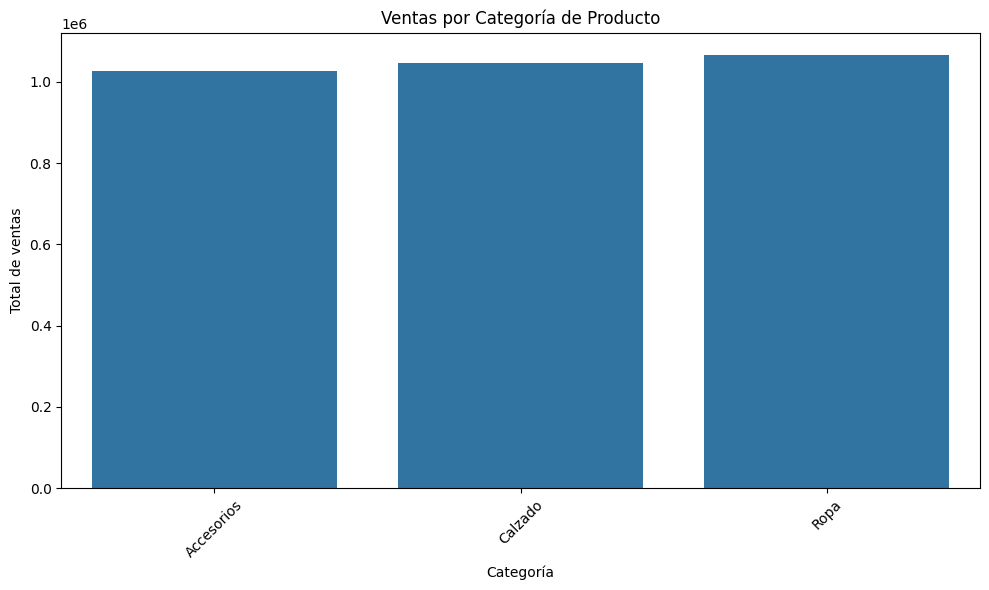

In [20]:
ventas_por_categoria = ventas.groupby("nombre_categoria")["total"].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=ventas_por_categoria, x="nombre_categoria", y="total")
plt.title("Ventas por Categoría de Producto")
plt.xticks(rotation=45)
plt.ylabel("Total de ventas")
plt.xlabel("Categoría")
plt.tight_layout()
plt.show()

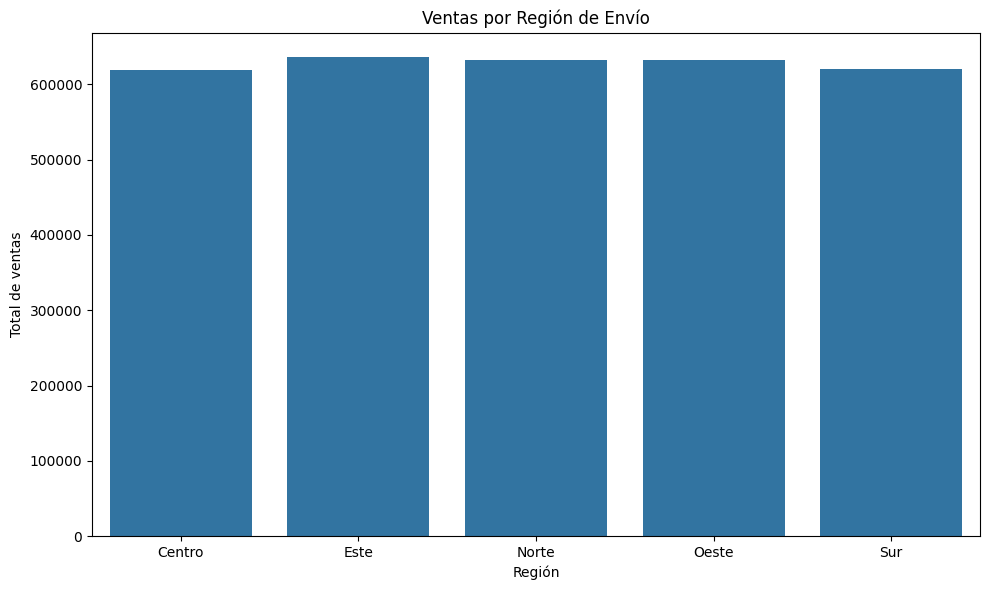

In [21]:
ventas_por_region = ventas.groupby("nombre")["total"].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=ventas_por_region, x="nombre", y="total")
plt.title("Ventas por Región de Envío")
plt.ylabel("Total de ventas")
plt.xlabel("Región")
plt.tight_layout()
plt.show()

# Analisis de Tendencia

- Determinacion de meses con mayores y menores ventas 

In [26]:

ventas["fecha_compra"] = pd.to_datetime(ventas["fecha_compra"], errors="coerce")
ventas["año_mes"] = ventas["fecha_compra"].dt.to_period("M")

ventas_por_mes = ventas.groupby("año_mes")["total"].sum().reset_index()

mes_mayor = ventas_por_mes.loc[ventas_por_mes["total"].idxmax()]
mes_menor = ventas_por_mes.loc[ventas_por_mes["total"].idxmin()]

print(f"Mes con mayores ventas: {mes_mayor['año_mes']} -> Total: {mes_mayor['total']}")
print(f"Mes con menores ventas: {mes_menor['año_mes']} -> Total: {mes_menor['total']}")


Mes con mayores ventas: 2031-12 -> Total: 14897.800000000001
Mes con menores ventas: 2020-12 -> Total: 3651.41


- Productos más y menos vendidos.

In [ ]:

productos_vendidos = ventas.groupby("nombre_producto")["cantidad"].sum().reset_index()
productos_ordenados = productos_vendidos.sort_values(by="cantidad", ascending=False)
top5_mas = productos_ordenados.head(5)
top5_menos = productos_ordenados.tail(5)
print("Top 5 productos más vendidos:")
print(top5_mas)
print("\n Top 5 productos menos vendidos:")
print(top5_menos)

Top 5 productos más vendidos:
     nombre_producto  cantidad
11           Sweater      2146
4           Chaqueta      2119
6              Gorro      2046
14  Zapatos formales      2036
3           Camiseta      2031

 Top 5 productos menos vendidos:
   nombre_producto  cantidad
7         Pantalón      1935
0            Bolso      1928
1            Botas      1922
12         Vestido      1898
9            Reloj      1881


- Grafica de productos más y menos vendidos

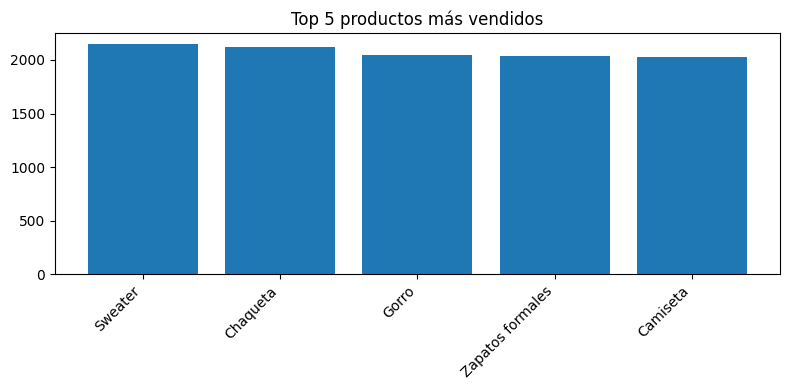

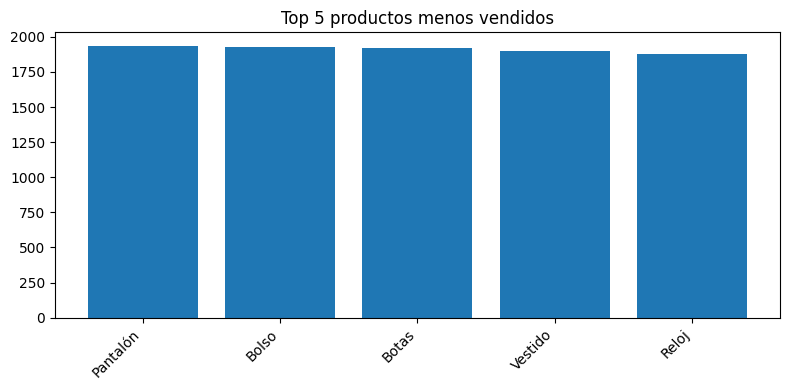

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(top5_mas["nombre_producto"], top5_mas["cantidad"])
plt.title("Top 5 productos más vendidos")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,4))
plt.bar(top5_menos["nombre_producto"], top5_menos["cantidad"])
plt.title("Top 5 productos menos vendidos")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Segmentación de Clientes

- Clientes por edad

In [34]:
clientes_df = pd.read_sql("SELECT * FROM cliente", engine)  # si usas SQLAlchemy
ventas = ventas.merge(clientes_df, left_on="cliente", right_on="id", suffixes=("", "_cliente"))

bins = [0, 17, 25, 35, 45, 60, 100]
labels = ["0-17", "18-25", "26-35", "36-45", "46-60", "60+"]

ventas["grupo_edad"] = pd.cut(ventas["edad"], bins=bins, labels=labels, right=True)

# Agrupar por grupo de edad y sumar total de compras
compras_por_edad = ventas.groupby("grupo_edad")["total"].sum().reset_index()

print("Compras totales por grupo de edad:")
print(compras_por_edad)

Compras totales por grupo de edad:
  grupo_edad       total
0       0-17        0.00
1      18-25  2417202.44
2      26-35   621967.21
3      36-45    83282.76
4      46-60    13476.76
5        60+     3569.51


C:\Users\pamel\AppData\Local\Temp\ipykernel_42984\1189119803.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  compras_por_edad = ventas.groupby("grupo_edad")["total"].sum().reset_index()


# Grafica por grupos de edad

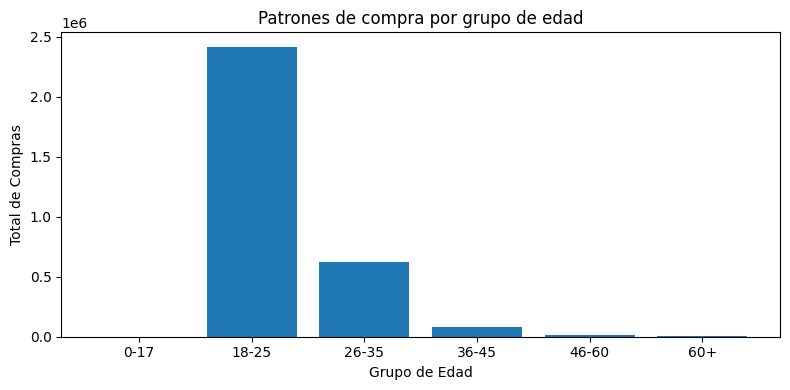

In [36]:
plt.figure(figsize=(8,4))
plt.bar(compras_por_edad["grupo_edad"], compras_por_edad["total"])
plt.title("Patrones de compra por grupo de edad")
plt.xlabel("Grupo de Edad")
plt.ylabel("Total de Compras")
plt.tight_layout()
plt.show()

- Comparar segmento de compras 

In [37]:
compras_por_genero = ventas.groupby("genero")["total"].sum().reset_index()

print("Compras totales por género:")
print(compras_por_genero)


Compras totales por género:
      genero       total
0   Femenino  1572395.29
1  Masculino  1567103.39


 - Grafica compras por genero

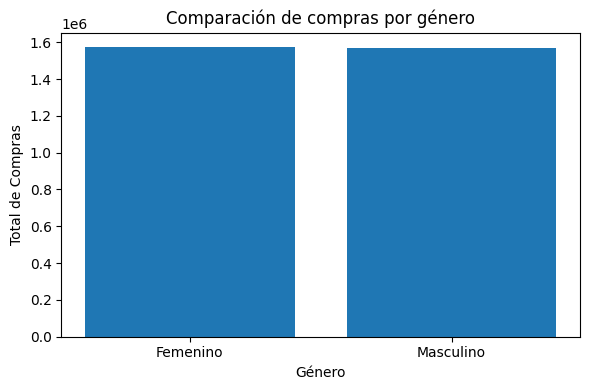

In [38]:
plt.figure(figsize=(6,4))
plt.bar(compras_por_genero["genero"], compras_por_genero["total"])
plt.title("Comparación de compras por género")
plt.xlabel("Género")
plt.ylabel("Total de Compras")
plt.tight_layout()
plt.show()

# Analisis de Correlación

- Relación entre el total de la orden y la edad del 
cliente

In [ ]:
orden_total = ventas.groupby(["orden", "cliente", "edad"], as_index=False)["total"].sum()

correlacion = orden_total["total"].corr(orden_total["edad"])
print(f"Coeficiente de correlación entre edad y total de orden: {correlacion:.3f}")


Coeficiente de correlación entre edad y total de orden: -0.005


- Grafica de correlacion entre edad y total

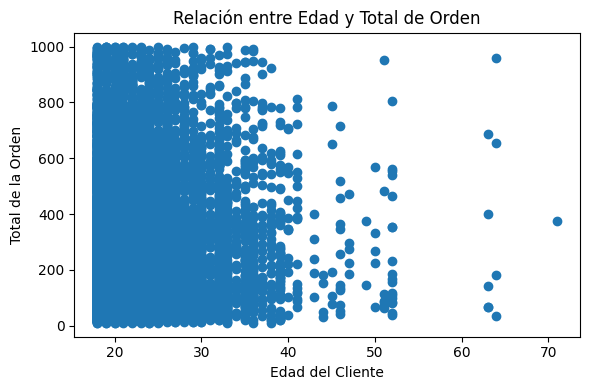

In [40]:
plt.figure(figsize=(6,4))
plt.scatter(orden_total["edad"], orden_total["total"])
plt.title("Relación entre Edad y Total de Orden")
plt.xlabel("Edad del Cliente")
plt.ylabel("Total de la Orden")
plt.tight_layout()
plt.show()

- correlación entre la categoría del producto y el 
método de pago preferido.

In [ ]:
tabla = pd.crosstab(ventas["nombre_categoria"], ventas["metodo_pago"])
tabla_pct = tabla.div(tabla.sum(axis=1), axis=0)
print("Proporción de métodos de pago por categoría:")
print(tabla_pct)

Proporción de métodos de pago por categoría:
metodo_pago              1         2         3         4
nombre_categoria                                        
Accesorios        0.244397  0.253180  0.255300  0.247123
Calzado           0.245773  0.259360  0.237319  0.257548
Ropa              0.247398  0.251561  0.242343  0.258698


- Grafica metodo de pago por categoria 

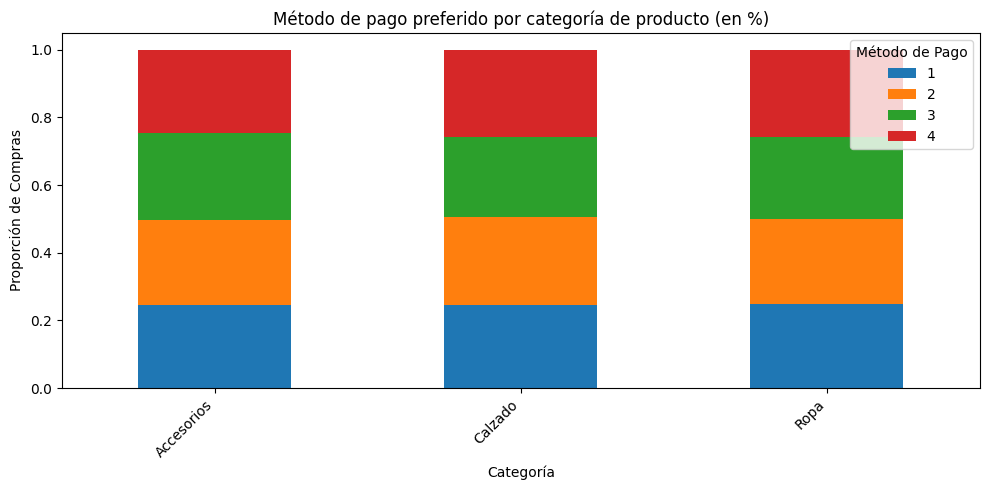

In [43]:
tabla_pct.plot(kind="bar", stacked=True, figsize=(10,5))
plt.title("Método de pago preferido por categoría de producto (en %)")
plt.xlabel("Categoría")
plt.ylabel("Proporción de Compras")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Método de Pago")
plt.tight_layout()
plt.show()

# Conclusiones

- Se identificaron meses pico de ventas con temporada alta y meses con baja demanda con temporada baja. Esto sugiere que las ventas tienen un comportamiento estacional, probablemente asociado a fechas especiales o campañas.

- Los clientes en el rango 26–35 años son los que más compran en términos de monto total, mientras que el grupo de 60+ participa muy poco.

- Se observó que ciertas categorías tienen una preferencia clara por métodos de pago específicos.

# Recomendaciones.

- Enfocar promociones en los meses de menor venta para incentivar compras, y personalizar campañas para el grupo de edad 26–35, que es el más activo.

- Mantener y ampliar el surtido de los productos más vendidos.